In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Supervised Contrastive (SimCLR) loss vs Cross Entropy (Normal): 

### initial experiment

In [3]:
clf_val  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_finetuning_checkpoint_300__2021_02_05_14_25_loss.csv')
norm_val = pd.read_csv('./record/Encoder_64-128-256-512-128-7_mode_normal_on_exp4csi_finetuning_checkpoint_300__2021_02_04_17_42_loss.csv')
clf_acc  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_finetuning_checkpoint_300__2021_02_05_14_25_accuracy.csv')
norm_acc = pd.read_csv('./record/Encoder_64-128-256-512-128-7_mode_normal_on_exp4csi_finetuning_checkpoint_300__2021_02_04_17_42_accuracy.csv')
clf_pre = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_pretrain_checkpoint_500__2021_02_05_14_19_loss.csv')
clf_cmtx  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_finetuning_checkpoint_300__2021_02_05_14_25_cmtx.csv',index_col=0)
norm_cmtx = pd.read_csv('./record/Encoder_64-128-256-512-128-7_mode_normal_on_exp4csi_finetuning_checkpoint_300__2021_02_04_17_42_cmtx.csv',index_col=0)

For dataset, we use 80% of the dataset as training set, it consist of 6 activities: walking, sitting, standing (from chair), laying down and picking up (we exclude 'standing from floor' to reduce possible confusion in this stage)

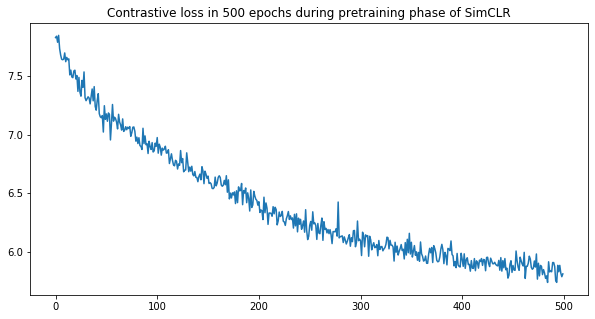

In [4]:
clf_pre['train_loss'].plot(figsize=(10,5),title='Contrastive loss in 500 epochs during pretraining phase of SimCLR')

In contrastive training, the distance (cosine distance/euclidean distance) between the two vectors from two labels are pulling away from each other, and essentially, the contrastive training is a cluster process. With different clusters, we need to build a classifier to perform the classification. In SimCLR, it does so by replacing the projection head with a classifier. Thus,  training a classifier is always necessary.   
The model, consisted of four layers encoder and linear projection head (128,) is trained with 500 epochs and SGD with learning rate of $10^{-5}$ for pretraining as previously suggested, the loss is with the decrease trend and fluctuated due to the stochastic nature of SGD

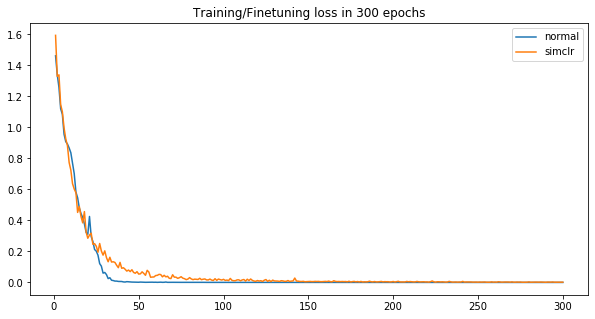

In [5]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,301),norm_val['train_loss'].values)
plt.plot(np.arange(1,301),clf_val['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 300 epochs')
plt.show()

After pretraining, we discard the projection head, freeze the encoder, and build a mlp (128--6) on top of it. And finetune with cross entropy, with 300 epochs and ADAM with learning rate of $10^{-5}$. To compare, we train a normal model for comparision with the same architecutre and setting (except freezing the encoder) 
Above shows the training loss in normal setting decrease much faster than in pretrained setting. 

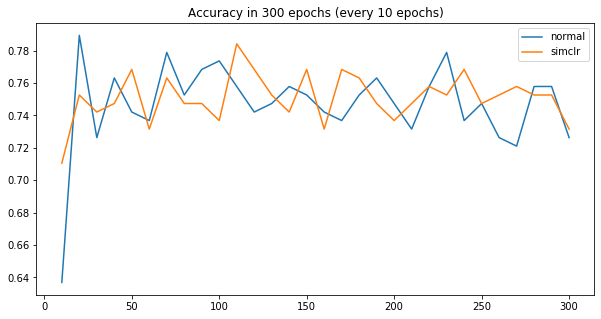

In [6]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,310,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,310,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 300 epochs (every 10 epochs)')
plt.show()

For the actually accuracy. In general, they reach a similar level of 72-76%. With the pretraining, the model reach above 70% in first 10 epochs, significantly better than the normal. After that, they perform similarily. 

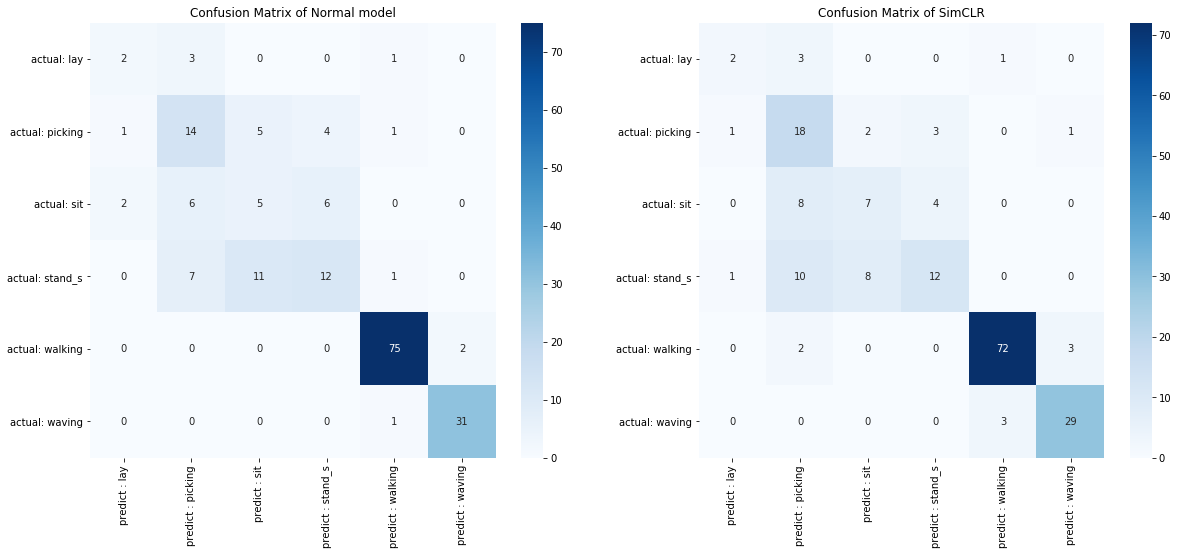

In [7]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True)
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True)
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()

Here are the confusion matrix

### pretrained with 4000 epoch, classes applied by oversampled train set and undersampled test set

In [2]:
clf_pre = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_s_resampled_4000epochs_pretrain_checkpoint_4000__2021_02_08_22_43_loss.csv')
clf_loss  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_s_resampled_4000epochs_finetuning_checkpoint_200__2021_02_08_22_51_loss.csv')
clf_acc  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_s_resampled_4000epochs_finetuning_checkpoint_200__2021_02_08_22_51_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_s_resampled_4000epochs_finetuning_checkpoint_200__2021_02_08_22_51_cmtx.csv',index_col=0)

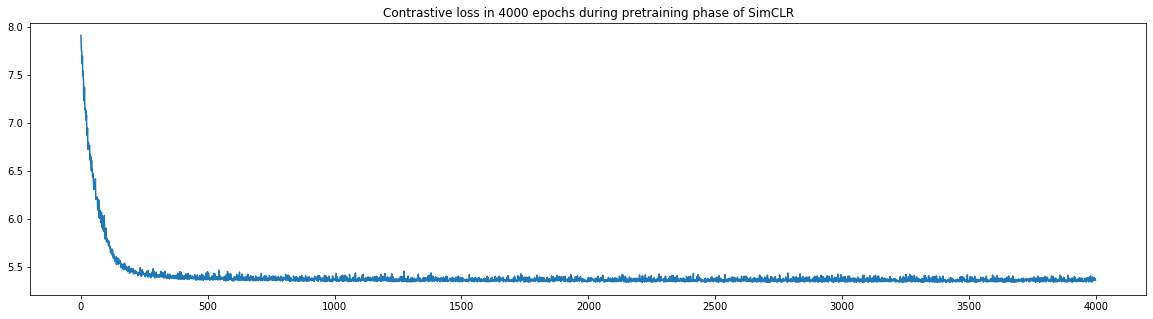

In [4]:
clf_pre['train_loss'].plot(figsize=(20,5),title='Contrastive loss in 4000 epochs during pretraining phase of SimCLR')

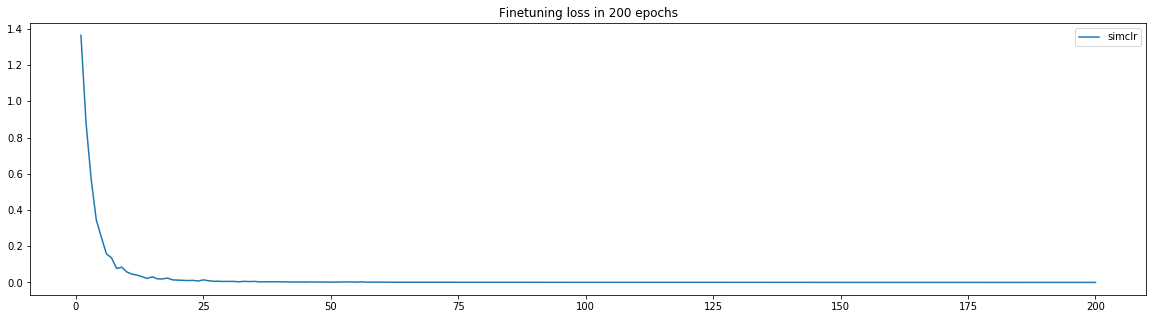

In [7]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(1,201),clf_loss['train_loss'].values)
plt.legend(['simclr'])
plt.title('Finetuning loss in 200 epochs')
plt.show()

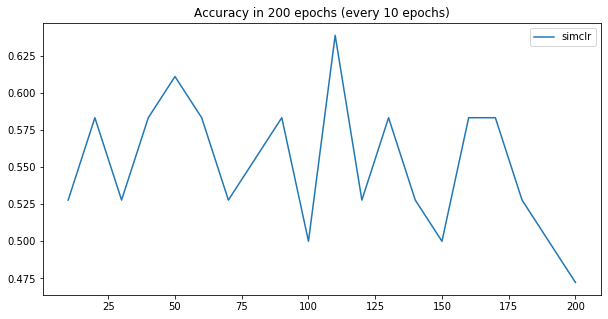

In [8]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,210,10),clf_acc['validation_accuracy'].values)
plt.legend(['simclr'])
plt.title('Accuracy in 200 epochs (every 10 epochs)')
plt.show()

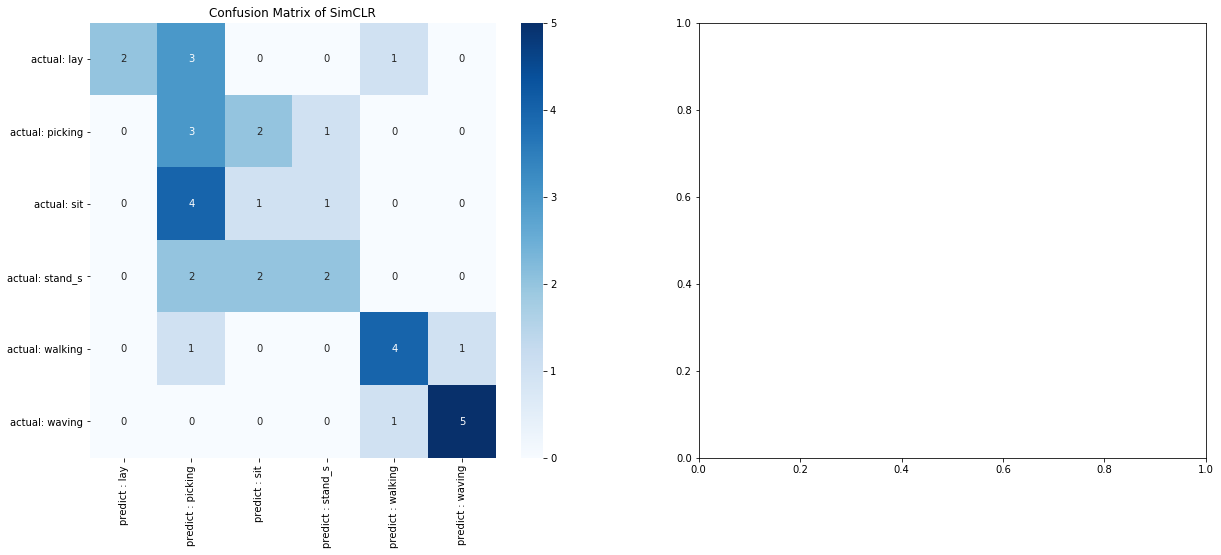

In [9]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(clf_cmtx,ax=axs[0],cmap='Blues',annot=True)
axs[0].set_title('Confusion Matrix of SimCLR')
plt.show()

# 2. self-supervised contrastive learning: single modality (2 NUC)  

In data collection, we use two receivers to collect CSI from single transmitter. Utilise this nature, we perfrom an self-supervised contrastive learning, where we group the two spectrogram that collected simultanously as positive pair while making the others as negative pair.  

**Setup**

* Encoder: VGG-16
* Dataset: All 6 activities except "standing from the ground". All sepctrograms are randomly seperated into train and validation set. The train set is further speerated, where all of the spectrograms are used for pertraining and $p$ of the spectrograms are used for fintuning.

* batch size: 64
* Epochs: 600 (pretrain), 200 (finetuning/training) 
* optimizer: SGD (pretraining), ADAM (finetuning/training)
* loss: NT-Xent (pretraining), Cross-entropy (finetuning/training)


### $p$ = 1

In [4]:
clf_pre = pd.read_csv('./record/'+'Encoder_vgg16_mode_clf_on_exp4csipair_pretrain_checkpoint_800__2021_02_11_23_40_loss.csv')

In [5]:
clf_expname = 'Encoder_vgg16_mode_clf_on_exp4csipair_finetuning_checkpoint_200__2021_02_11_23_47'
clf_loss  = pd.read_csv('./record/'+clf_expname+'_loss.csv')
clf_acc  = pd.read_csv('./record/'+clf_expname+'_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/'+clf_expname+'_cmtx.csv',index_col=0)

norm_expname = 'Encoder_vgg16_mode_normal_on_exp4csipair_finetuning_checkpoint_200__2021_02_12_16_02'
norm_loss  = pd.read_csv('./record/'+norm_expname+'_loss.csv')
norm_acc  = pd.read_csv('./record/'+norm_expname+'_accuracy.csv')
norm_cmtx  = pd.read_csv('./record/'+norm_expname+'_cmtx.csv',index_col=0)

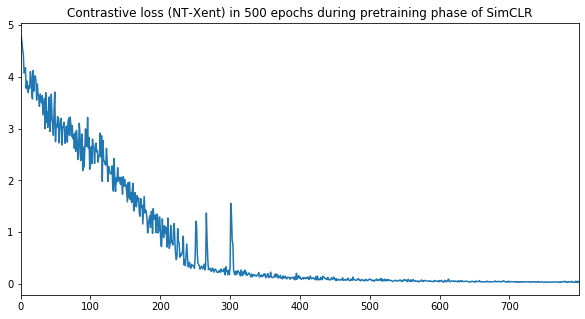

In [6]:
clf_pre['train_loss'].plot(figsize=(10,5),title='Contrastive loss (NT-Xent) in 500 epochs during pretraining phase of SimCLR')

We can see the loss between 0 to 200 epochs shows a constant decreasing trend. Experiencing a spike of increase between 200 to 300 epochs, the loss converges approximately at  400 epochs

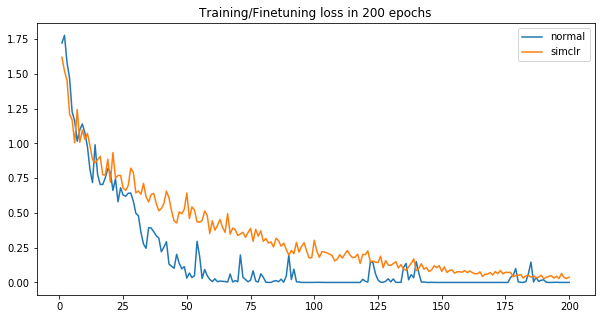

In [7]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,201),norm_loss['train_loss'].values)
plt.plot(np.arange(1,201),clf_loss['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 200 epochs')
plt.show()

Comparing between the normal training and finetuning(simclr), the former converge at 75 epochs, significantly faster than the latter, it also experience more unstable spikes afterward.  

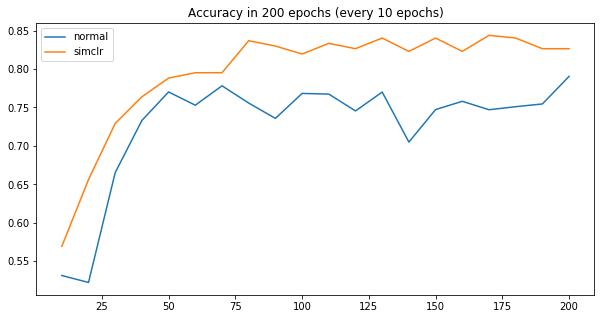

In [8]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,210,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,210,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 200 epochs (every 10 epochs)')
plt.show()

Unlike the loss, the model train after simclr is significantly better than the normal model during the entire fine-tuning/training.  

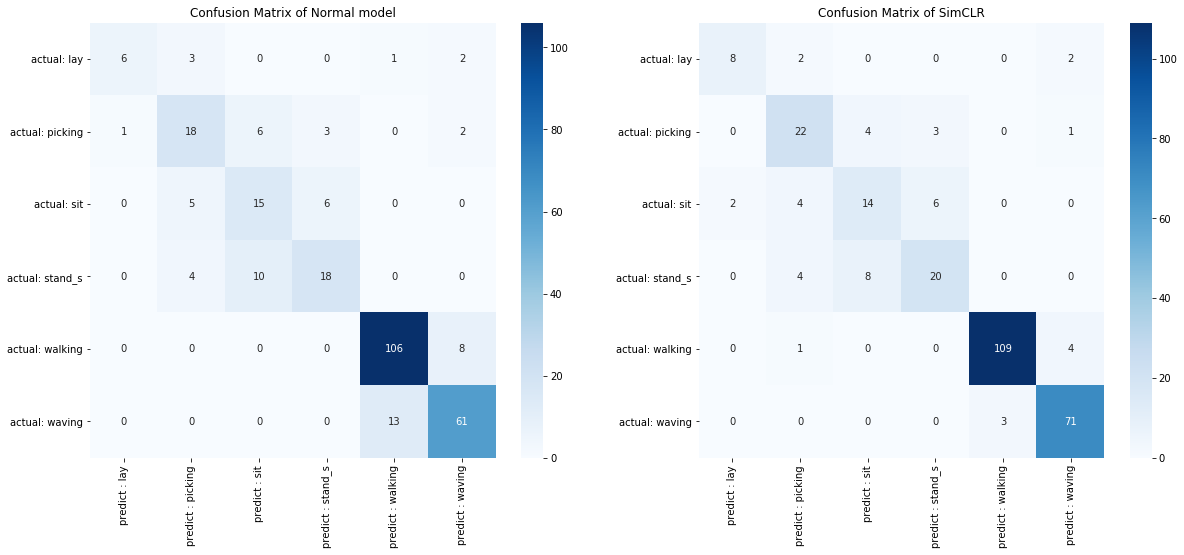

In [9]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True, fmt='g')
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True, fmt='g')
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()

### $p$ = 0.5

In [31]:
clf_expname = 'Encoder_vgg16_mode_clf_on_exp4csipair_s_p050_finetuning_checkpoint_300__2021_02_12_17_14'
clf_loss  = pd.read_csv('./record/'+clf_expname+'_loss.csv')
clf_acc  = pd.read_csv('./record/'+clf_expname+'_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/'+clf_expname+'_cmtx.csv',index_col=0)
norm_expname = 'Encoder_vgg16_mode_normal_on_exp4csipair_s_p050_finetuning_checkpoint_300__2021_02_12_17_33'
norm_loss  = pd.read_csv('./record/'+norm_expname+'_loss.csv')
norm_acc  = pd.read_csv('./record/'+norm_expname+'_accuracy.csv')
norm_cmtx  = pd.read_csv('./record/'+norm_expname+'_cmtx.csv',index_col=0)

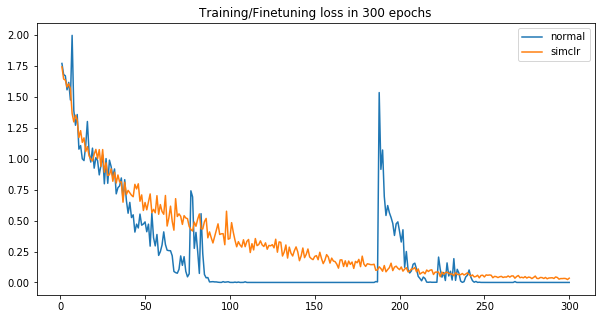

In [34]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,301),norm_loss['train_loss'].values)
plt.plot(np.arange(1,301),clf_loss['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 300 epochs')
plt.show()

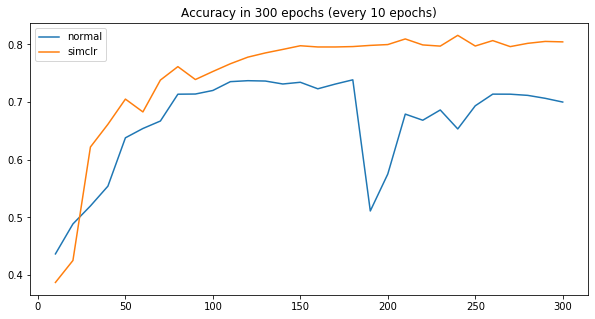

In [35]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,310,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,310,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 300 epochs (every 10 epochs)')
plt.show()

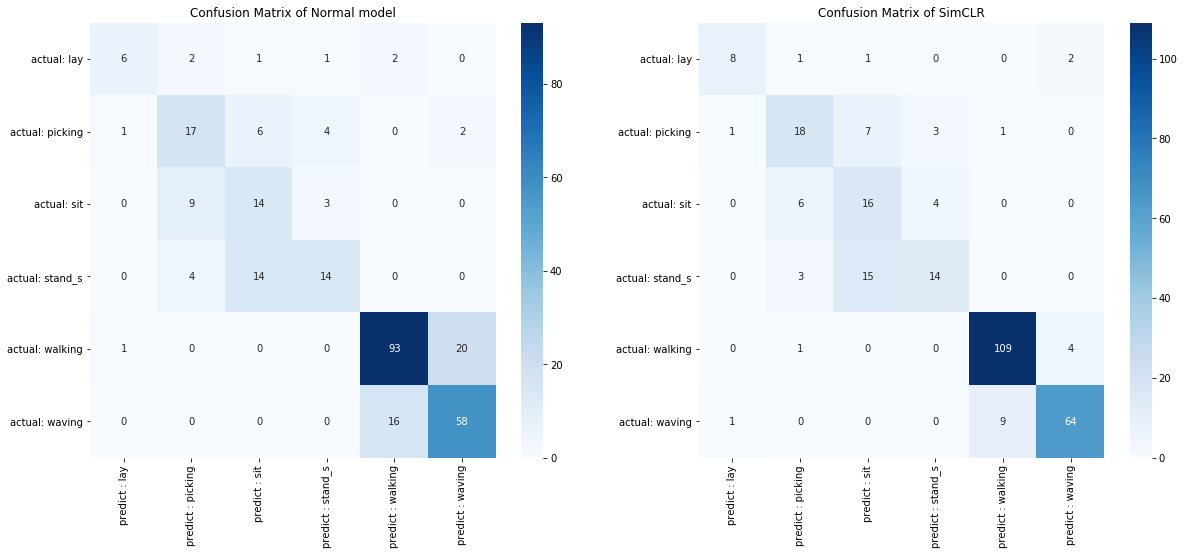

In [36]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True, fmt='g')
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True, fmt='g')
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()

### $p$ = 0.25

In [27]:
clf_expname = 'Encoder_vgg16_mode_clf_on_exp4csipair_s_p025_finetuning_checkpoint_200__2021_02_12_16_24'
clf_loss  = pd.read_csv('./record/'+clf_expname+'_loss.csv')
clf_acc  = pd.read_csv('./record/'+clf_expname+'_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/'+clf_expname+'_cmtx.csv',index_col=0)
norm_expname = 'Encoder_vgg16_mode_normal_on_exp4csipair_s_p025_finetuning_checkpoint_200__2021_02_12_16_34'
norm_loss  = pd.read_csv('./record/'+norm_expname+'_loss.csv')
norm_acc  = pd.read_csv('./record/'+norm_expname+'_accuracy.csv')
norm_cmtx  = pd.read_csv('./record/'+norm_expname+'_cmtx.csv',index_col=0)

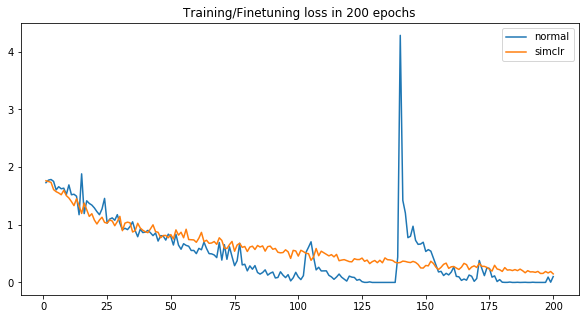

In [28]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,201),norm_loss['train_loss'].values)
plt.plot(np.arange(1,201),clf_loss['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 200 epochs')
plt.show()

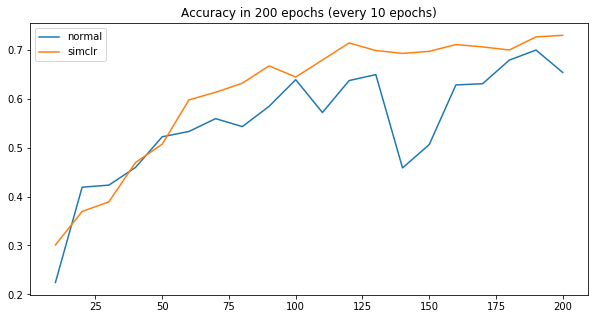

In [29]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,210,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,210,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 200 epochs (every 10 epochs)')
plt.show()

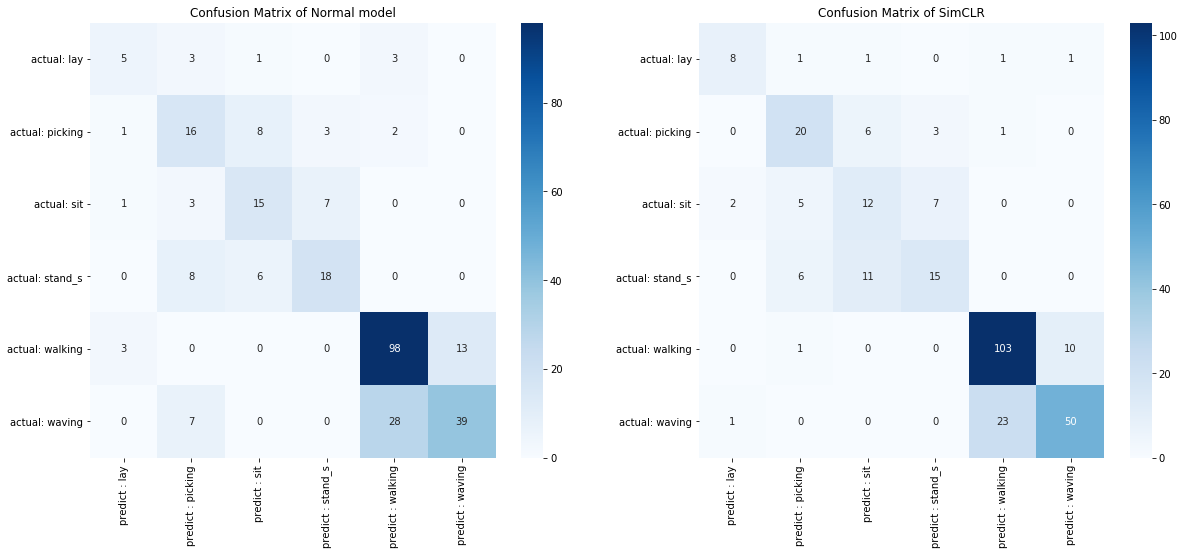

In [30]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True, fmt='g')
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True, fmt='g')
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()

### $p$ = 0.1

In [23]:
clf_expname = 'Encoder_vgg16_mode_clf_on_exp4csipair_s_p010_finetuning_checkpoint_300__2021_02_12_16_47'
clf_loss  = pd.read_csv('./record/'+clf_expname+'_loss.csv')
clf_acc  = pd.read_csv('./record/'+clf_expname+'_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/'+clf_expname+'_cmtx.csv',index_col=0)
norm_expname = 'Encoder_vgg16_mode_normal_on_exp4csipair_s_p010_finetuning_checkpoint_300__2021_02_12_17_00'
norm_loss  = pd.read_csv('./record/'+norm_expname+'_loss.csv')
norm_acc  = pd.read_csv('./record/'+norm_expname+'_accuracy.csv')
norm_cmtx  = pd.read_csv('./record/'+norm_expname+'_cmtx.csv',index_col=0)

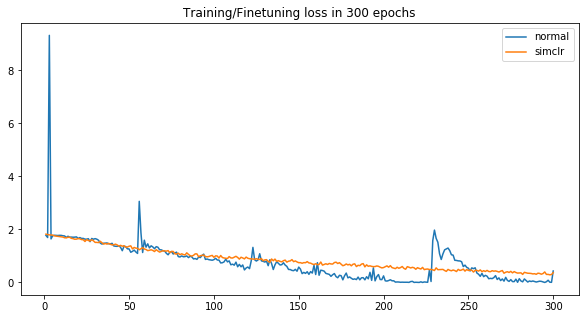

In [24]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,301),norm_loss['train_loss'].values)
plt.plot(np.arange(1,301),clf_loss['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 300 epochs')
plt.show()

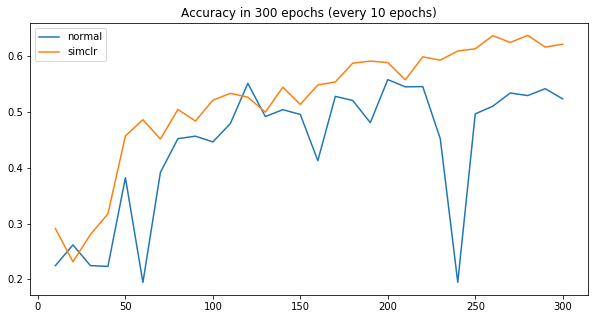

In [25]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,310,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,310,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 300 epochs (every 10 epochs)')
plt.show()

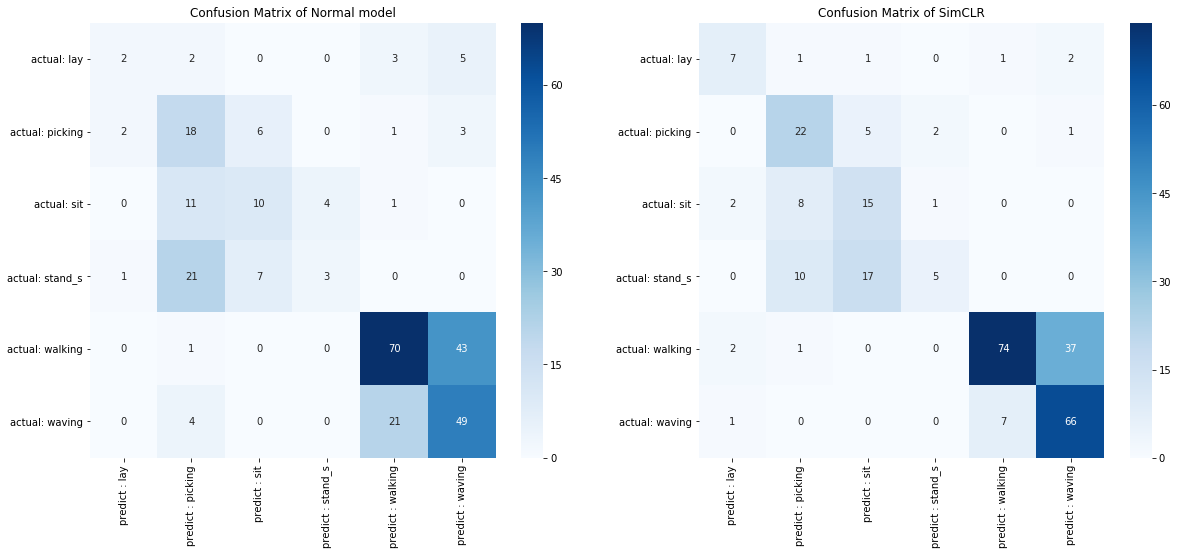

In [26]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True, fmt='g')
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True, fmt='g')
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()

### resampled

In [41]:
clf_expname = 'Encoder_vgg16_mode_clf_on_exp4csipair_s_resampledataset_finetuning_checkpoint_200__2021_02_12_17_52'
clf_loss  = pd.read_csv('./record/'+clf_expname+'_loss.csv')
clf_acc  = pd.read_csv('./record/'+clf_expname+'_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/'+clf_expname+'_cmtx.csv',index_col=0)
norm_expname = 'Encoder_vgg16_mode_normal_on_exp4csipair_s_resampledataset_finetuning_checkpoint_300__2021_02_12_18_36'
norm_loss  = pd.read_csv('./record/'+norm_expname+'_loss.csv')
norm_acc  = pd.read_csv('./record/'+norm_expname+'_accuracy.csv')
norm_cmtx  = pd.read_csv('./record/'+norm_expname+'_cmtx.csv',index_col=0)

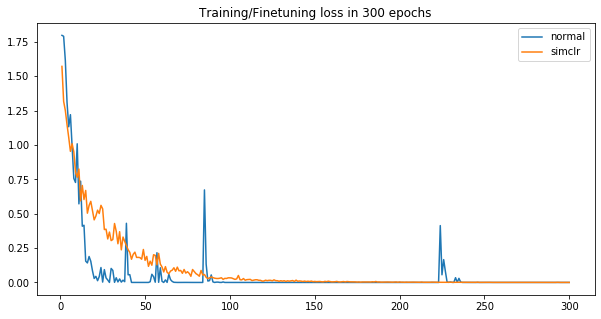

In [42]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,301),norm_loss['train_loss'].values)
plt.plot(np.arange(1,301),clf_loss['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 300 epochs')
plt.show()

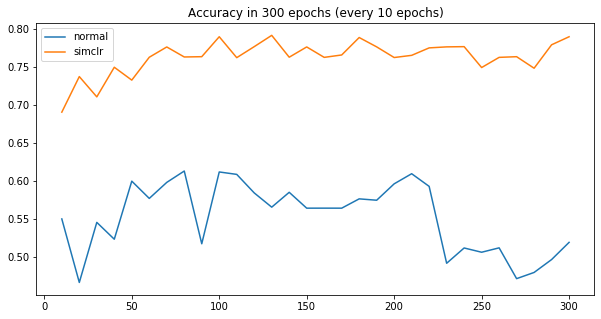

In [43]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,310,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,310,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 300 epochs (every 10 epochs)')
plt.show()

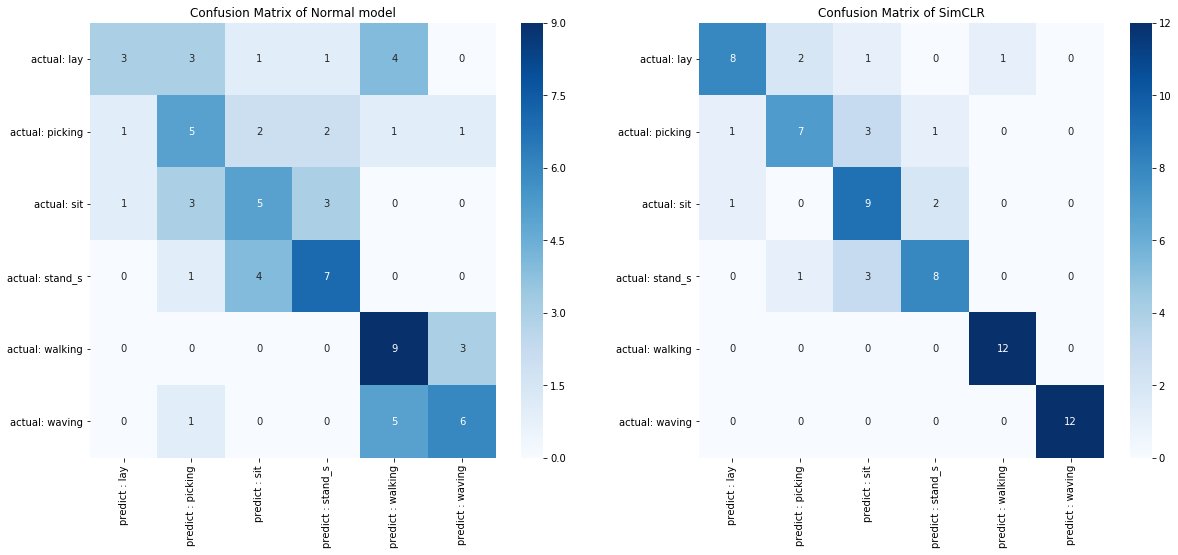

In [44]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True, fmt='g')
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True, fmt='g')
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()

# 3. self-supervised contrastive learning: multi-modality (NUC1 & PWR)

In [3]:
clf_pre = pd.read_csv('./record/'+'Encoder_vgg16_mode_clf_on_exp4csipwr_pretrain_checkpoint_800__2021_02_17_16_16_loss.csv')

In [36]:
clf_expname = 'Encoder_vgg16_mode_clf_on_exp4csipwr_finetuning_checkpoint_300__2021_02_17_16_21'
clf_loss  = pd.read_csv('./record/'+clf_expname+'_loss.csv')
clf_acc  = pd.read_csv('./record/'+clf_expname+'_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/'+clf_expname+'_cmtx.csv',index_col=0)
clf_repo = pd.read_csv('./record/'+clf_expname+'_report.csv',index_col=0)

norm_expname = 'Encoder_vgg16_mode_clf_on_exp4csipair_finetuning_checkpoint_200__2021_02_11_23_47'
norm_loss  = pd.read_csv('./record/'+norm_expname+'_loss.csv')
norm_acc  = pd.read_csv('./record/'+norm_expname+'_accuracy.csv')
norm_cmtx  = pd.read_csv('./record/'+norm_expname+'_cmtx.csv',index_col=0)
norm_repo = pd.read_csv('./record/'+norm_expname+'_report.csv',index_col=0)

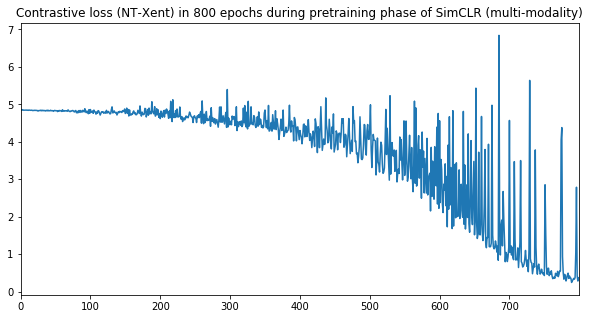

In [10]:
clf_pre['train_loss'].plot(figsize=(10,5),title='Contrastive loss (NT-Xent) in 800 epochs during pretraining phase of SimCLR (multi-modality)')

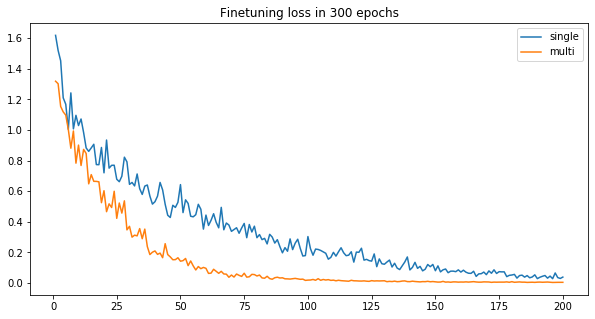

In [24]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,201),norm_loss['train_loss'].values)
plt.plot(np.arange(1,201),clf_loss['train_loss'].values[:200])
plt.legend(['single','multi'])
plt.title('Finetuning loss in 300 epochs')
plt.show()

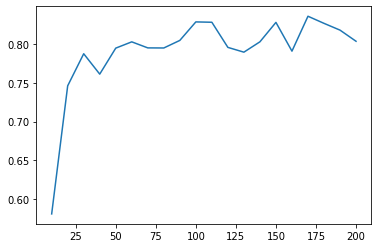

In [30]:
plt.plot(np.arange(10,210,10),clf_acc['validation_accuracy'].values[:20])

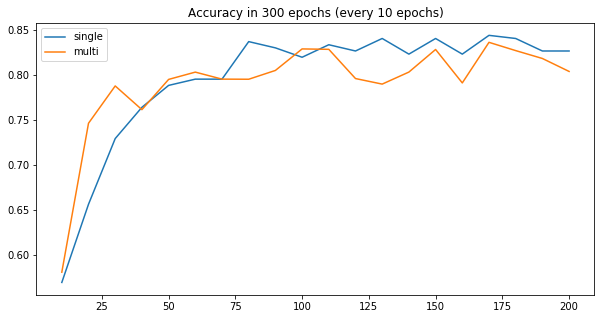

In [32]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,210,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,210,10),clf_acc['validation_accuracy'].values[:20])
plt.legend(['single','multi'])
plt.title('Accuracy in 300 epochs (every 10 epochs)')
plt.show()

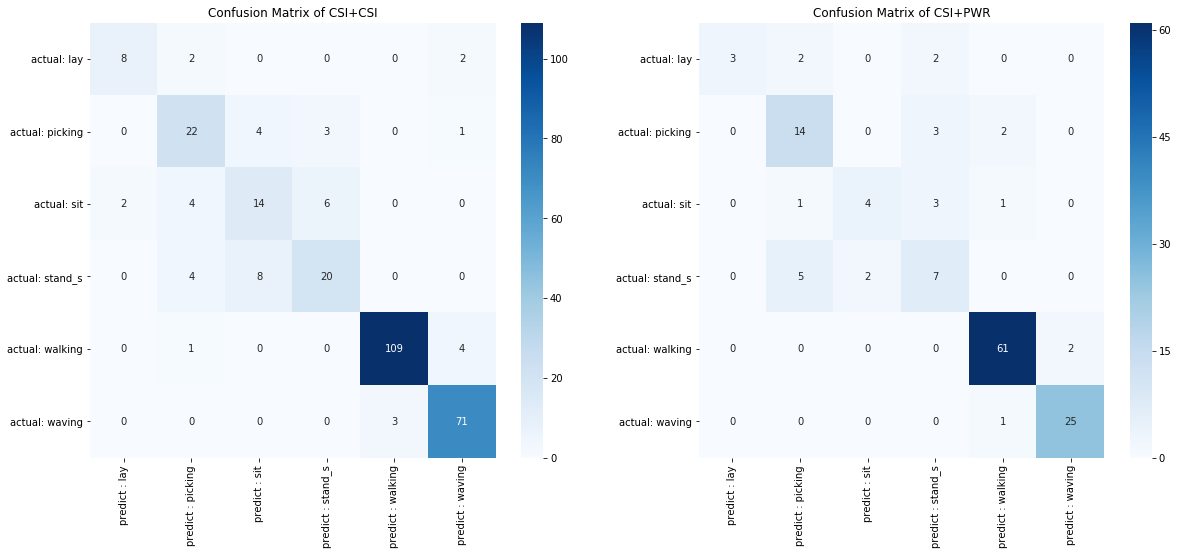

In [33]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True, fmt='g')
axs[0].set_title('Confusion Matrix of CSI+CSI')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True, fmt='g')
axs[1].set_title('Confusion Matrix of CSI+PWR')
plt.show()

In [39]:
# Multi modality
clf_repo

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
f1-score,0.600000,0.682927,0.533333,0.482759,0.953125,0.943396,0.826087,0.699257,0.821083
precision,1.000000,0.636364,0.666667,0.466667,0.938462,0.925926,0.826087,0.772347,0.832039
recall,0.428571,0.736842,0.444444,0.500000,0.968254,0.961538,0.826087,0.673275,0.826087
support,7.000000,19.000000,9.000000,14.000000,63.000000,26.000000,0.826087,138.000000,138.000000


In [40]:
# Single modality
norm_repo

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
f1-score,0.727273,0.698413,0.538462,0.655738,0.964602,0.934211,0.847222,0.753116,0.846387
precision,0.800000,0.666667,0.538462,0.689655,0.973214,0.910256,0.847222,0.763042,0.847133
recall,0.666667,0.733333,0.538462,0.625000,0.956140,0.959459,0.847222,0.746510,0.847222
support,12.000000,30.000000,26.000000,32.000000,114.000000,74.000000,0.847222,288.000000,288.000000


# Full sample

Similar to the previous experiment, we compare the performance of the network with and without pre-training. For this experiment, we add an extra class stand_l (standing from laying), in total 7 classes. In addition, we train/fine-tune the network with weighting.

Experiment setup as below
1. Encoder: VGG16 
2. mode: normal (without pre-training), simclr (contrastive pre-training)
3. pretraining data: CSI_nuc1+CSI_nuc2, CSI_nuc1+PWR
4. training data: CSI_nuc1, CSI_nuc2, PWR
5. batch size: 64
6. epoch: 800(pretraining), 300 (training/fine-tuning)

X1_train:  (605, 1, 65, 501)    X2_train:  (605, 1, 65, 501)

X_train:  (605, 1, 65, 501)     y_train:  (605,)        X_test:  (152, 1, 65, 501)      y_test:  (152,) 

class:  \['lay' 'picking' 'sit' 'stand_l' 'stand_s' 'walking' 'waving'\] 

class_size:  \[0.0579, 0.1421, 0.1091, 0.0496, 0.1025, 0.3223, 0.2165\]

In [2]:
col_dic = {'0':'lay','1':'picking','2':'sit','3':'stand_l','4':'stand_s','5':'walking','6':'waving'}

def store(expname):
    dic = {}
    dic['loss']  = pd.read_csv('./record/'+expname+'_loss.csv')
    dic['acc']  = pd.read_csv('./record/'+expname+'_accuracy.csv')
    dic['cmtx']  = pd.read_csv('./record/'+expname+'_cmtx.csv',index_col=0)
    repo = pd.read_csv('./record/'+expname+'_report.csv',index_col=0).copy()
    repo.rename(columns = col_dic, inplace = True) 
    dic['repo'] = repo
    return dic

def multiple_plots(objs,key,titles,figsize=(20,8)):
    assert len(objs) == len(titles)
    length = len(objs)
    f,axs = plt.subplots(round(length/2),2,figsize=figsize)
    for i,(obj,title) in enumerate(zip(objs,titles)):
        sns.heatmap(obj[key],ax=axs[i//2][i%2],cmap='Blues',annot=True, fmt='g')
        axs[i//2][i%2].set_title(title)
    plt.show()
    return

First we have a look at the performance of the model under normal condition

In [3]:
norm_1 = store('Trainmode-normal_Network-vgg16_Data-exp4csicsi-1_checkpoint_300__2021_02_24_12_35')
norm_2 = store('Trainmode-normal_Network-vgg16_Data-exp4csicsi-2_checkpoint_300__2021_02_24_12_52')
norm_j = store('Trainmode-normal_Network-vgg16_Data-exp4csicsi-j_checkpoint_300__2021_02_24_15_45')
norm_p = store('Trainmode-normal_Network-vgg16_Data-exp4csipwr-2_checkpoint_300__2021_02_24_22_01')

In [37]:
l2reg_1 = store('Trainmode-normal_Network-vgg16_Data-exp4csicsi-1_s-l2reg_checkpoint_300__2021_02_25_14_03')

In [61]:
# nuc 1
norm_1['repo'] 

,lay,picking,sit,stand_l,stand_s,walking,waving,accuracy,macro avg,weighted avg
f1-score,0.333333,0.409091,0.303030,0.500000,0.258065,0.907407,0.821429,0.638158,0.504622,0.644683
precision,0.285714,0.529412,0.294118,0.714286,0.190476,0.942308,0.741935,0.638158,0.528321,0.677215
recall,0.400000,0.333333,0.312500,0.384615,0.400000,0.875000,0.920000,0.638158,0.517921,0.638158
support,5.000000,27.000000,16.000000,13.000000,10.000000,56.000000,25.000000,0.638158,152.000000,152.000000


In [53]:
# nuc 2
norm_2['repo']

,lay,picking,sit,stand_l,stand_s,walking,waving,accuracy,macro avg,weighted avg
f1-score,0.4,0.488889,0.512821,0.222222,0.545455,0.867925,0.813559,0.671053,0.550124,0.662443
precision,0.3,0.611111,0.434783,0.400000,0.500000,0.920000,0.705882,0.671053,0.553111,0.686339
recall,0.6,0.407407,0.625000,0.153846,0.600000,0.821429,0.960000,0.671053,0.595383,0.671053
support,5.0,27.000000,16.000000,13.000000,10.000000,56.000000,25.000000,0.671053,152.000000,152.000000


* It is expected that the model perform differently when we train the model with data source from different locations

In [62]:
# we average the score to find the model performance when we train with the data source seperately
(norm_1['repo'] + norm_2['repo']) / 2

,lay,picking,sit,stand_l,stand_s,walking,waving,accuracy,macro avg,weighted avg
f1-score,0.366667,0.448990,0.407925,0.361111,0.401760,0.887666,0.817494,0.654605,0.527373,0.653563
precision,0.292857,0.570261,0.364450,0.557143,0.345238,0.931154,0.723909,0.654605,0.540716,0.681777
recall,0.500000,0.370370,0.468750,0.269231,0.500000,0.848214,0.940000,0.654605,0.556652,0.654605
support,5.000000,27.000000,16.000000,13.000000,10.000000,56.000000,25.000000,0.654605,152.000000,152.000000


In [55]:
# nuc 1 + nuc 2
norm_j['repo']

,lay,picking,sit,stand_l,stand_s,walking,waving,accuracy,macro avg,weighted avg
f1-score,0.608696,0.478261,0.514286,0.577778,0.313725,0.921659,0.854545,0.707237,0.609850,0.709276
precision,0.538462,0.578947,0.473684,0.684211,0.258065,0.952381,0.783333,0.707237,0.609869,0.725624
recall,0.700000,0.407407,0.562500,0.500000,0.400000,0.892857,0.940000,0.707237,0.628966,0.707237
support,10.000000,54.000000,32.000000,26.000000,20.000000,112.000000,50.000000,0.707237,304.000000,304.000000


In [38]:
l2reg_1['repo']

,lay,picking,sit,stand_l,stand_s,walking,waving,accuracy,macro avg,weighted avg
f1-score,0.133333,0.571429,0.482759,0.166667,0.500000,0.840000,0.756757,0.651316,0.492992,0.634618
precision,0.166667,0.600000,0.538462,0.250000,0.470588,0.823529,0.682927,0.651316,0.504596,0.626735
recall,0.111111,0.545455,0.437500,0.125000,0.533333,0.857143,0.848485,0.651316,0.494004,0.651316
support,9.000000,22.000000,16.000000,8.000000,15.000000,49.000000,33.000000,0.651316,152.000000,152.000000


* Overall, when we combine the two data sources to train the model, we can see the performance increase in many activities, with an exception of "standing s".


In [56]:
# pwr
norm_p['repo']

,lay,picking,sit,stand_l,stand_s,walking,waving,accuracy,macro avg,weighted avg
f1-score,0.615385,0.666667,0.500000,0.0,0.625000,0.896000,0.793651,0.776224,0.585243,0.776006
precision,0.666667,0.566667,0.571429,0.0,0.714286,0.888889,0.862069,0.776224,0.610001,0.787130
recall,0.571429,0.809524,0.444444,0.0,0.555556,0.903226,0.735294,0.776224,0.574210,0.776224
support,7.000000,21.000000,9.000000,1.0,9.000000,62.000000,34.000000,0.776224,143.000000,143.000000


* While the overall accuracy is significantly higher wiht PWR than CSI, we see it could not predict the activty "stand_l" 

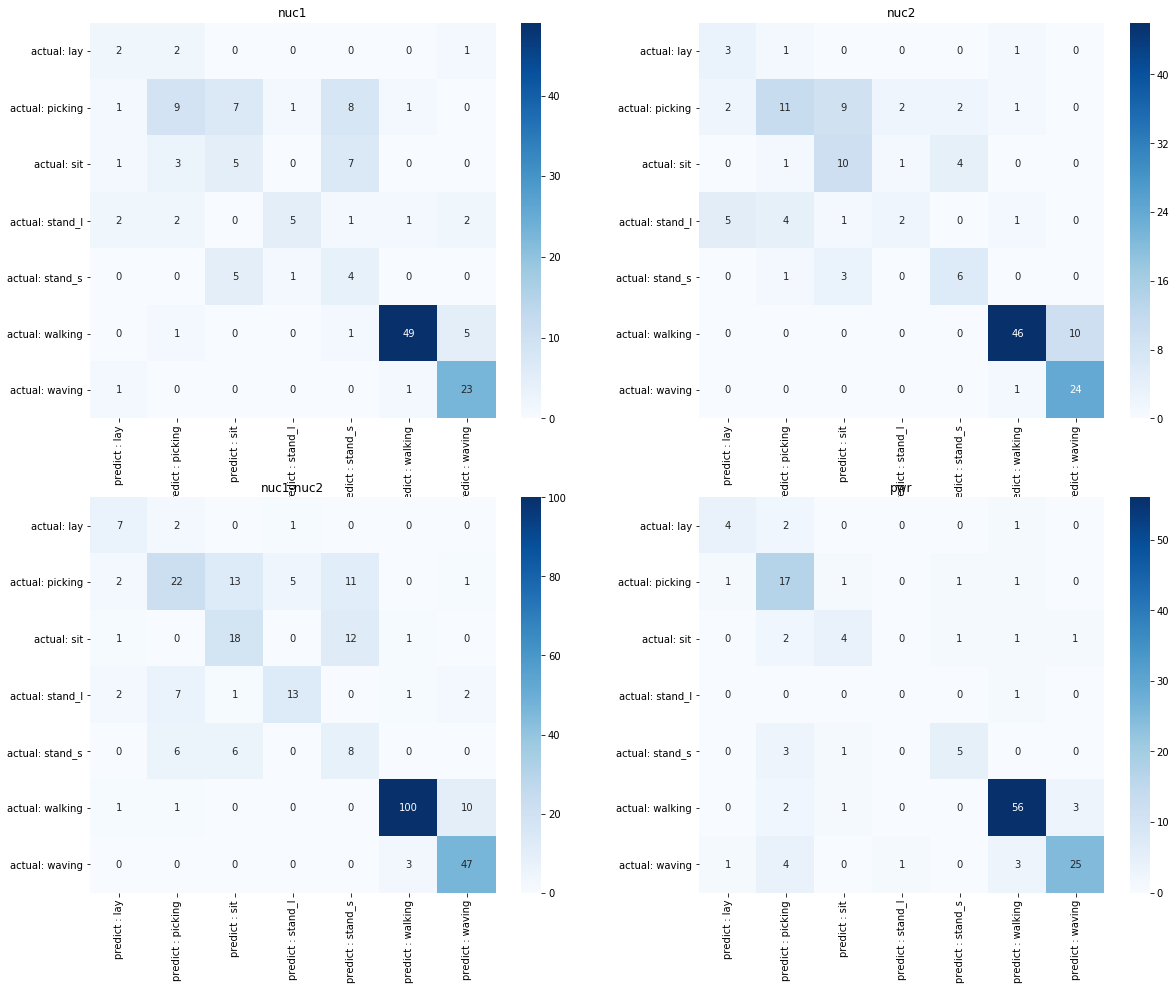

In [41]:
multiple_plots(objs=[norm_1,norm_2,norm_j,norm_p],
               key='cmtx',
               titles=['nuc1','nuc2','nuc1-nuc2','pwr'],
               figsize=(20,16))

### SimCLR (with csi-nuc2 / pwr)

In [16]:
simclr_1 =  store('Trainmode-simclr_Network-vgg16_Data-exp4csicsi-1_checkpoint_300__2021_02_24_19_57')
simclr_j =  store('Trainmode-simclr_Network-vgg16_Data-exp4csicsi-j_checkpoint_300__2021_02_24_14_14')
simclr_p1 = store('Trainmode-simclr_Network-vgg16_Data-exp4csipwr-1_checkpoint_300__2021_02_25_13_29')

In [9]:
pretrain_p1 = pd.read_csv('./record/'+'Trainmode-simclr_Network-vgg16_Data-exp4csipwr-1_checkpoint_800__2021_02_25_13_22_loss.csv')
pretrain_1  = pd.read_csv('./record/'+'Trainmode-simclr_Network-vgg16_Data-exp4csicsi-1_checkpoint_800__2021_02_24_19_49_loss.csv')

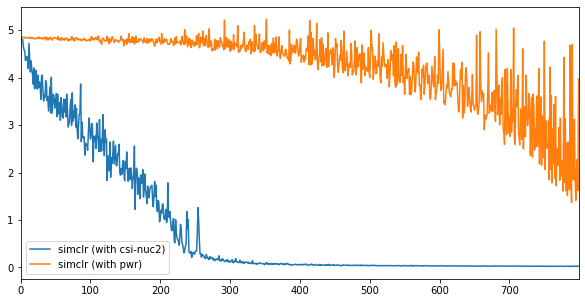

In [15]:
# pre-traing losses
pretrain_1['train_loss'].plot(figsize=(10,5))
pretrain_p1['train_loss'].plot(figsize=(10,5))
plt.legend(['simclr (with csi-nuc2)','simclr (with pwr)'])

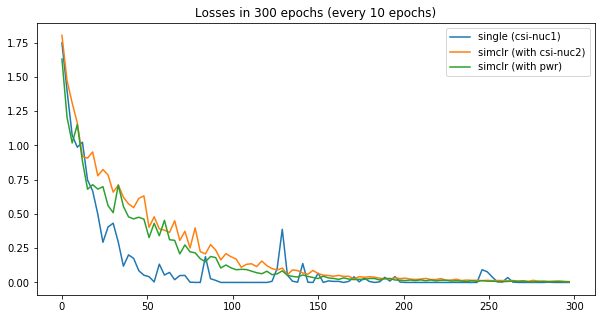

In [25]:
skp = 3
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,300,skp),norm_j['loss']['train_loss'].values[::skp])
plt.plot(np.arange(0,300,skp),simclr_1['loss']['train_loss'].values[::skp])
plt.plot(np.arange(0,300,skp),simclr_p1['loss']['train_loss'].values[::skp])
plt.legend(['single (csi-nuc1)','simclr (with csi-nuc2)','simclr (with pwr)'])
plt.title('Losses in 300 epochs (every 10 epochs)')
plt.show()

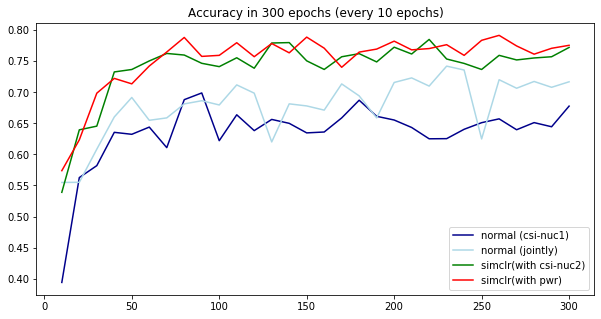

In [36]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,310,10),norm_1['acc']['validation_accuracy'].values,color="darkblue")
plt.plot(np.arange(10,310,10),norm_j['acc']['validation_accuracy'].values,color="lightblue")
plt.plot(np.arange(10,310,10),simclr_1['acc']['validation_accuracy'].values,color="green")
plt.plot(np.arange(10,310,10),simclr_p1['acc']['validation_accuracy'].values,color="red")
plt.legend(['normal (csi-nuc1)','normal (jointly)','simclr(with csi-nuc2)','simclr(with pwr)'])
plt.title('Accuracy in 300 epochs (every 10 epochs)')
plt.show()

In [20]:
# with nuc 1
simclr_1['repo'] 

,lay,picking,sit,stand_l,stand_s,walking,waving,accuracy,macro avg,weighted avg
f1-score,0.307692,0.763636,0.709677,0.500000,0.608696,0.910714,0.8,0.769737,0.657202,0.770384
precision,0.250000,0.750000,0.733333,0.714286,0.538462,0.910714,0.8,0.769737,0.670971,0.782261
recall,0.400000,0.777778,0.687500,0.384615,0.700000,0.910714,0.8,0.769737,0.665801,0.769737
support,5.000000,27.000000,16.000000,13.000000,10.000000,56.000000,25.0,0.769737,152.000000,152.000000


In [21]:
# with pwr
simclr_p1['repo'] 

,lay,picking,sit,stand_l,stand_s,walking,waving,accuracy,macro avg,weighted avg
f1-score,0.444444,0.857143,0.588235,0.5,0.636364,0.875000,0.754717,0.79021,0.665129,0.784117
precision,0.500000,0.807692,0.625000,0.5,0.700000,0.835821,0.833333,0.79021,0.685978,0.784991
recall,0.400000,0.913043,0.555556,0.5,0.583333,0.918033,0.689655,0.79021,0.651374,0.790210
support,5.000000,23.000000,9.000000,4.0,12.000000,61.000000,29.000000,0.79021,143.000000,143.000000


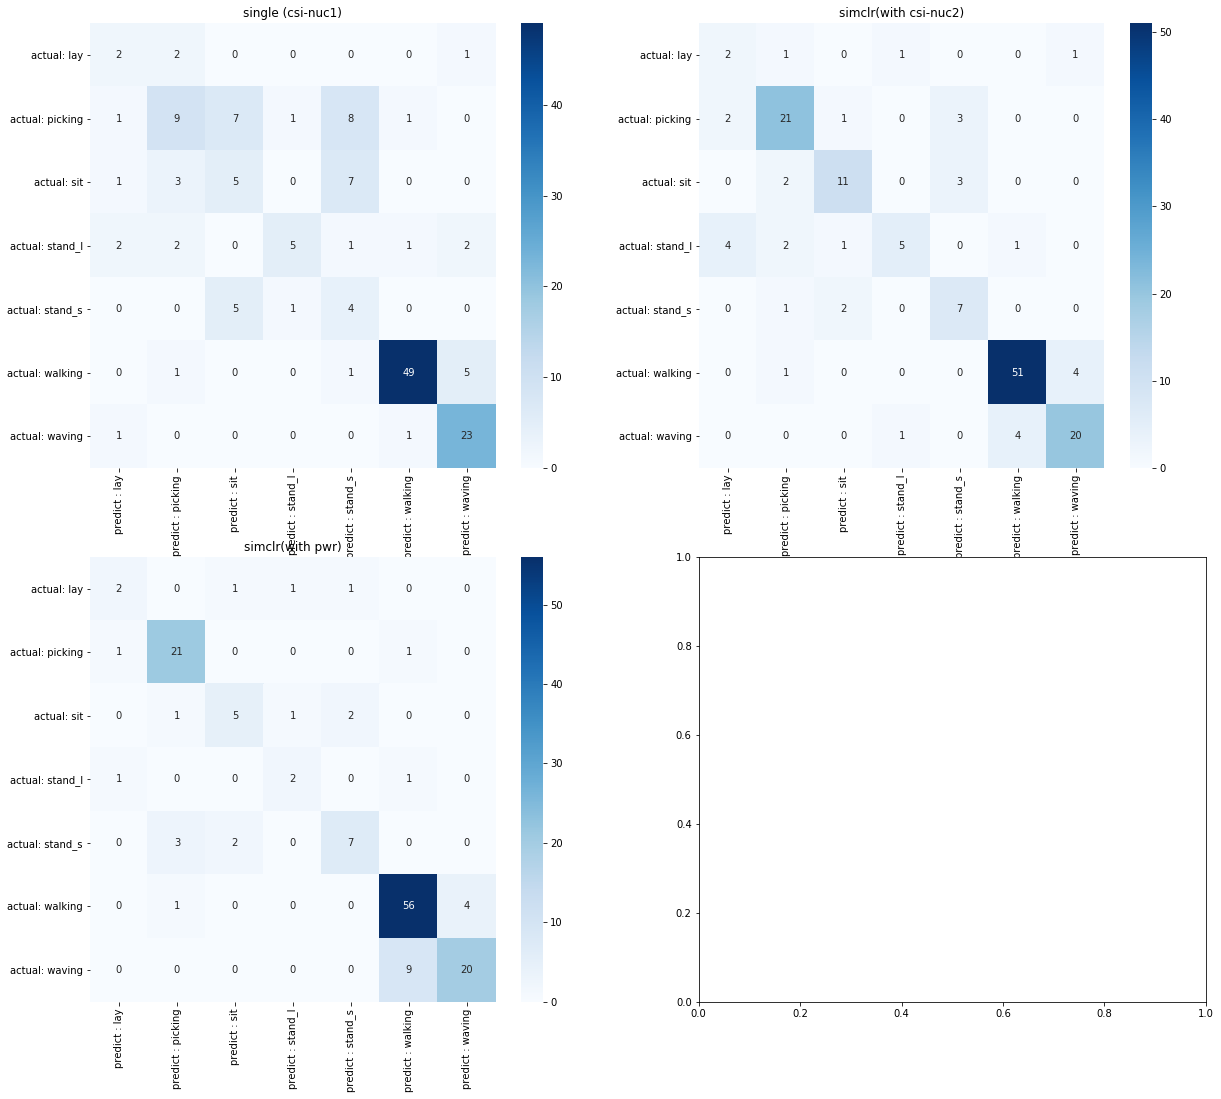

In [19]:
multiple_plots(objs=[norm_1,simclr_1,simclr_p1],
               key='cmtx',
               titles=['single (csi-nuc1)','simclr(with csi-nuc2)','simclr(with pwr)'],
               figsize=(20,18))